# Mutual Information-based Registration

## Introduction

This exercise focuses on registration based on a mutual information (MI). To enable fully-automated registration processes, even when the anatomical structures exhibit differing intensity features, mutual information between two images can be maximized. The goal is to analyze the frequency at which specific discretized intensity pairs ($f, w$) appear for a given set of transformation parameters $w$. For this purpose, the fixed and moving images are pre-processed to include only B discrete intensity levels.

In Task 2, a joint histogram is generated, where each entry $h_{f,m}$ indicates how frequently a particular intensity in image $f$ corresponds to a respective intensity in the moving image $m$. 
The histogram can be represented as:

$$
H=\begin{pmatrix}
h_{1,1} & \cdots & h_{1,B}\\
\vdots & \ddots & \vdots\\
h_{B,1} & \cdots & h_{B,B}\\
\end{pmatrix}
$$

To calculate mutual information in Task 3, we use the function $MI = H_F + H_M - H_{F,M}$ and apply it to compute MI between the T1-weighted image and the resampled T2-weighted image. In Task 4, we evaluate MI across a range of rotation angles using the 3D rotation matrix formula $\mathbf{R} = \mathbf{R}_z \mathbf{R}_y \mathbf{R}_x$.

In Task 5 and Task 6, we perform automatic registration and plot the energy function $E(\mathbf{w}) = H_{F,M} - H_F - H_M$ for each angle in the grid search. We then compare the joint histogram before and after registration.

This method minimizes the negative of mutual information.

### Input data and code hints
Import Python libraries:

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
#%matplotlib notebook
# %matplotlib tk
plt.ion()
np.set_printoptions( suppress=True )
import nibabel as nib
import scipy
from scipy.ndimage import map_coordinates,affine_transform



Read the two 3D scans you'll be working with in this exercise:

In [2]:
T1_fileName = 'IXI014-HH-1236-T1.nii.gz'
T2_fileName = 'IXI014-HH-1236-T2_rotated.nii.gz'
T1 = nib.load( T1_fileName )
T2 = nib.load( T2_fileName )
T1_data = T1.get_fdata()
T2_data = T2.get_fdata()

Below is code to define a simple interactive viewer class that can be used to visualize 2D cross-sections of a 3D array along three orthogonal directions. It takes a 3D volume as input and shows the location a "linked cursor" in all three cross-sections.

The initial location of the cursor is in the middle of the volume in each case. It can be changed by clicking on one of the cross-sections. The viewer also displays the voxel index $\mathbf{v}$ of the cursor.

In [3]:
class Viewer:
    def __init__(self, data ):
        self.fig, self.ax = plt.subplots()
        self.data = data
        self.dims = self.data.shape
        self.position = np.round( np.array( self.dims ) / 2 ).astype( int )
        self.draw()
        self.fig.canvas.mpl_connect( 'button_press_event', self )
        self.fig.show()

    def __call__(self, event):
        print( 'button pressed' )
        if event.inaxes is None: return
      
        x, y = round( event.xdata ), round( event.ydata )

        #
        if ( x > (self.dims[0]-1) ) and ( y <= (self.dims[1]-1) ): return # lower-right quadrant
          
        #
        if x < self.dims[0]:
          self.position[ 0 ] = x
        else:
          self.position[ 1 ] = x - self.dims[0]
        
        if y < self.dims[1]:
          self.position[ 1 ] = y
        else:
          self.position[ 2 ] = y -self.dims[1]
        
        print( f"  voxel index: {self.position}" )
        print( f"  intensity: {self.data[ self.position[0], self.position[1], self.position[2] ]}" )

        self.draw()

    def draw( self ):
        #
        # Layout on screen is like this:
        #
        #     ^            ^
        #  Z  |         Z  |
        #     |            |
        #     ----->        ---->  
        #       X             Y
        #     ^
        #  Y  |
        #     |
        #     ----->  
        #       X
        #
        dims = self.dims
        position = self.position
        
        xySlice = self.data[ :, :, position[ 2 ] ]
        xzSlice = self.data[ :, position[ 1 ], : ]
        yzSlice = self.data[ position[ 0 ], :, : ]
        
        kwargs = dict( vmin=self.data.min(), vmax=self.data.max(), 
                       origin='lower', 
                       cmap='gray',
                       picker=True )

        self.ax.clear()

        self.ax.imshow( xySlice.T, 
                        extent=( 0, dims[0]-1, 
                                 0, dims[1]-1 ), 
                        **kwargs )
        self.ax.imshow( xzSlice.T, 
                        extent=( 0, dims[0]-1, 
                                 dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )
        self.ax.imshow( yzSlice.T, extent=( dims[0], dims[0]+dims[1]-1, 
                                            dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )

        color = 'g'
        self.ax.plot( (0, dims[0]-1), (position[1], position[1]), color )
        self.ax.plot( (0, dims[0]+dims[1]-1), (dims[1]+position[2], dims[1]+position[2]), color )
        self.ax.plot( (position[0], position[0]), (0, dims[1]+dims[2]-1), color )
        self.ax.plot( (dims[0]+position[1], dims[0]+position[1]), (dims[1]+1, dims[1]+dims[2]-1), color )

        self.ax.set( xlim=(1, dims[0]+dims[1]), ylim=(0, dims[1]+dims[2]) )

        self.ax.text( dims[0] + dims[1]/2, dims[1]/2, 
                      f"voxel index: {position}",  
                      horizontalalignment='center', verticalalignment='center' )
  
        self.ax.axis( False )

        self.fig.canvas.draw()

---

### Task 1: Resample the T2-weighted scan to the image grid of the T1-weighted scan

In this task you perform the resampling just like in the landmark-based registration exercise. Find the voxel-to-voxel transformation between $\mathbf{v}_{T1}$ and $\mathbf{v}_{T2}$:

$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
.
$$
At the location $\mathbf{v}_{T2}$, you should then use cubic B-spline interpolation to determine the intensity in the T2-weighted scan, and store it at index $\mathbf{v}_{T1}$ in the newly created image.


In [4]:
T1_affine = T1.affine
T2_affine = T2.affine # 4x4 matrix for T2-weighted image

# Create a meshgrid for T1 voxel coordinates
V1, V2, V3 = np.meshgrid(np.arange(T1_data.shape[0]), 
                         np.arange(T1_data.shape[1]), 
                         np.arange(T1_data.shape[2]), indexing='ij')

# Stack the voxel coordinates into a 4xN matrix
T1_voxel_coords = np.vstack([V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)])

# Transform the T1 voxel coordinates into T2 voxel coordinates
T2_voxel_coords_n = np.linalg.inv(T2_affine) @ T1_affine @ T1_voxel_coords
T2_voxel_coords = T2_voxel_coords_n[:3,:]

# Resample the T2 data to the T1 grid
T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, T2_voxel_coords, order=3).reshape(T1_data.shape)



Once you have created the resampled T2-weighted data, visualize the T1-weighted and resampled T2-weighted volumes overlaid as follows:
    
        Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )

**Can you determine around what axis (in world coordinates) the rotation was simulated?**

 We believe the rotation was simulated in the z axis in the world coordinates.

 T2-weighted image


/var/folders/v6/q9xwr1gn2dvdngsx947dpj280000gn/T/ipykernel_17264/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


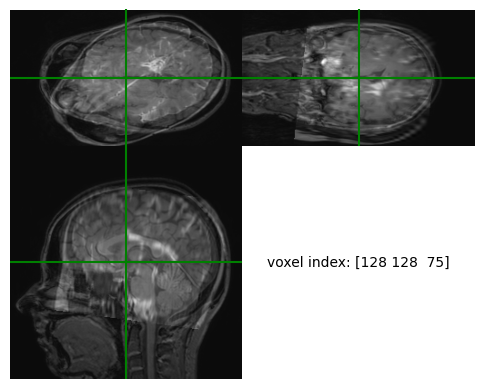

In [5]:
T2_viewer_r = Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )
print (" T2-weighted image")

T1 rotation matrix: [[ 0.01506851 -0.01498772  1.19969177]
 [-0.92914075  0.12376414  0.02165389]
 [ 0.12400278  0.92917383  0.01646696]]
T1 rotation matrix: [[-0.57081479 -0.68758535 -0.51340914]
 [-0.69109607  0.5740813  -0.01447279]
 [-0.06121002 -0.06962017  4.95120955]]
Global rotation matrix: [[ 0.77544818 -0.16582521 -0.86816572]
 [-0.68434491  0.0206479  -1.00794843]
 [ 0.02500879  0.18590633 -0.02157998]]


/var/folders/v6/q9xwr1gn2dvdngsx947dpj280000gn/T/ipykernel_17264/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


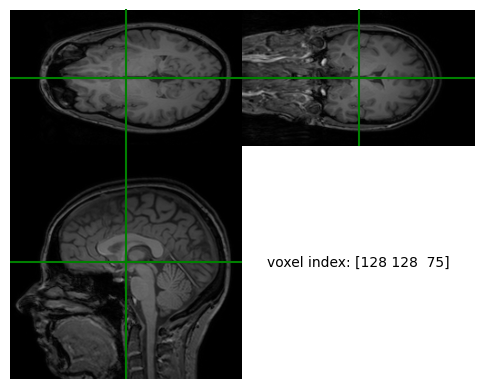

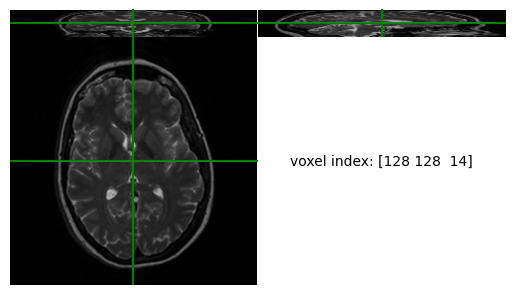

In [6]:
# Calculating around what axis the rotation was simulated
T1_rotation = T1_affine[:3,:3]
T2_rotation = T2_affine[:3,:3]
print ("T1 rotation matrix:",T1_rotation)
print ("T1 rotation matrix:",T2_rotation)

# Calculating the rotation matrix R= T2_rotation^-1 * T1_rotation 
R= np.linalg.inv(T2_rotation)@T1_rotation 
print ("Global rotation matrix:",R)

# We could compute the eigenvalues and eigenvector in order to get the axis it has been rotated. But just form inspection we can see the 
# the coronal cut of the image two has been rotated in the z-axis in the world coordinates
t1= Viewer (T1_data)
t2= Viewer (T2_data)


### Task 1: Explanations

In the first task, we aligned the T2-weighted MRI data with the voxel grid of the T1-weighted scan, to facilitate a direct comparison between the two images.

We began by generating a 3D meshgrid for the T1 voxel coordinates based on the scan's dimensions. These coordinates were then stacked into a matrix and converted into homogeneous coordinates by adding a row of ones. Next, we extracted the affine matrices for both the T1 and T2 scans, which map voxel indices to real-world coordinates (RAS space).

We computed a transformation matrix by multiplying the inverse of the T2 affine matrix with the T1 affine matrix and applied this transformation to the T1 voxel coordinates. This step allowed us to map the voxel coordinates from the T1 grid into the corresponding space of the T2 scan.

Using cubic interpolation, we resampled the T2 data at the transformed voxel coordinates to ensure smooth intensity transitions. The resampled T2 data was then reshaped to fit the T1 grid, resulting in a T2 volume that is precisely aligned with the T1-weighted image.

Finally, the resampled T2 data was visualized alongside the T1 data to provide a clear comparison for further analysis.

---

### Task 2: Compute and visualize the joint histogram

Compute the joint histogram 
$$ 
\mathbf{H} = 
\begin{pmatrix}
h_{1,1} & ... & h_{1,B} \\
\vdots & ... & \vdots \\
h_{B,1} & ... & h_{B,B} \\
\end{pmatrix} 
$$
of the T1-weighted scan and the resampled T2-weighted scan you just created, using $B=32$ bins. In order not to let the registration process be dominated by the (extremely numerous) background voxels, ignore all voxels with an intensity lower than 10 in either image when computing the histogram. Visualize the joint histogram using a 3D bar plot, and label the axes.

In [7]:
# We have to resample the data in order to compare the voxel intensities 
def mask(image1, image2, threshold=10):
    """
    Apply a mask to remove voxels below a given intensity threshold.
    """
    mask = (image1 >= threshold) & (image2 >= threshold)
    t1_masked = image1[mask]
    t2_masked = image2[mask]
    return t1_masked, t2_masked

def plot_3d_histogram(t1_masked, t2_masked, bins=32):
    """
    Plot a 3D histogram (joint histogram) of two masked image volumes.
    """
    hist, xedges, yedges = np.histogram2d(t1_masked.ravel(), t2_masked.ravel(), bins=bins)

    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)

    # Defining bar dimensions
    dx = (xedges[1] - xedges[0])  # width of each bar
    dy = (yedges[1] - yedges[0])  # depth of each bar 
    dz = hist.ravel() / np.sum(hist)  # height of each bar 

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz)

    ax.set_xlabel('T1 Intensity')
    ax.set_ylabel('T2 Intensity')
    ax.set_zlabel('Normalized Counts')

    plt.show()

    return hist


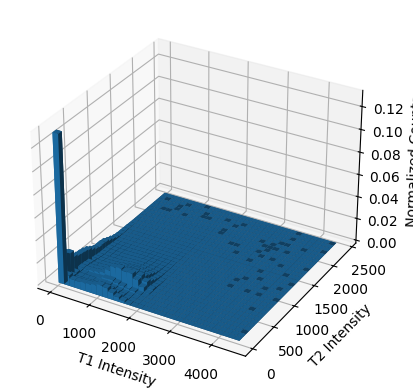

In [8]:
# Check if the data sizes are consistent
if T1_data.shape != T2_data_resampled.shape:
    raise ValueError("Recheck the sizes of the data: T1 and resampled T2 are not the same shape.")
else:
    # Masking the images
    t1_masked, t2_masked = mask(T1_data, T2_data_resampled, threshold=10)
    # Plot 3D histogram
    hist = plot_3d_histogram(t1_masked, t2_masked, bins=32)


### Task 2: Explanations

In this task, we calculated and visualized a joint histogram to compare the intensity distributions between the T1-weighted and T2-weighted MRI scans. First, we applied an intensity threshold to both images, excluding voxels with values below 10 (this step helps to eliminate background noise).

Next, we created a joint histogram with specified 32 bins for both the T1 and T2 intensities. This histogram captures how frequently pairs of intensities from the two scans occur together, revealing the relationship between their intensity distributions.

To visualize the joint histogram, we generated a 3D bar plot. The x and y coordinates of the bars correspond to the intensity bins for the T1 and T2 images, while the height of the bars represents the normalized frequency of intensity combinations.

---

### Task 3: Compute the mutual information between the two images
Write a function that takes two image volumes defined on the same image grid as input, and returns the mutual information between the two images:

$$ 
MI = H_{F} + H_{M} - H_{F,M} 
$$
with
$$ 
H_{F,M} = - \sum_{f=1}^{B} \sum_{m=1}^{B} p_{f,m} \log(p_{f,m}),
$$
$$ 
H_{F} = - \sum_{f=1}^{B} p_{f} \log(p_{f}), 
$$
and
$$
H_{M} = - \sum_{m=1}^{B} p_{m} \log(p_{m})
.
$$

Your function should make use of the joint histogram computed as in the previous task (i.e., using $B=32$ bins and ignoring all voxels with intensity lower than 10).

Use your new function to compute the mutual information between the T1-weighted image and the resampled T2-weighted image.

In [9]:
import numpy as np

def calculate_entropy(hist):
    """
    Calculate the entropy given a histogram.
    """
    # Normalize the histogram to get a joint probability distribution
    prob = hist / np.sum(hist)

    # Calculate entropy adding a small value to avoid log(0)
    non_zero_prob = prob + 1e-12
    entropy = -np.sum(non_zero_prob * np.log(non_zero_prob))

    return entropy

def calculate_mutual_information(hist, t1_masked, t2_masked, bins=32):
    """
    Calculate the mutual information based on marginal and joint histograms.
    """
    # Compute the marginal histograms for T1 and T2
    hist_T1, _ = np.histogram(t1_masked, bins=bins)
    hist_T2, _ = np.histogram(t2_masked, bins=bins)

    # Calculate entropies for the marginal and joint histograms
    H_T1 = calculate_entropy(hist_T1)
    H_T2 = calculate_entropy(hist_T2)
    H_joint = calculate_entropy(hist)

    # Mutual Information = Entropy(T1) + Entropy(T2) - Joint Entropy(T1, T2)
    mi = H_T1 + H_T2 - H_joint

    return mi
    

In [10]:
if T1_data.shape != T2_data_resampled.shape:
    raise ValueError("Recheck the sizes of the data: T1 and resampled T2 are not the same shape.")
else:
    # Calculate Mutual Information
    mi_value = calculate_mutual_information(hist, t1_masked, t2_masked, bins=32)
    print(f"Mutual Information between the two images: {mi_value}")

Mutual Information between the two images: 0.11674744070423237


### Task 3: Explanations

In the third task, we created a function to calculate the mutual information (MI) between two images. First, it expects the voxel data from both images to be pre-filtered, where voxels with values below a threshold have already been removed. This ensures that only meaningful intensity values are used.

The function computes a 2D joint histogram of voxel intensities between the two images and also calculates individual marginal histograms for each image. These histograms are normalized to represent the probability distributions of voxel intensities.

Using these probability distributions, the function calculates the three necessary entropies: the entropy for each individual image (T1 and T2) and the joint entropy between the two images. Finally, the mutual information is computed as the sum of the entropies for T1 and T2, minus the joint entropy, giving the measure of shared information between the two images - in our case the MI came out to be 0.11674744070423237.

---

### Task 4: Evaluate the mutual information across a range of rotation angles

Implement a grid search over a range of rotation angles, with the goal of identifying the angle with approximately the highest mutual information (i.e., where the registration is best). Make an educated guess of a suitable range by visually inspecting the images (or by simply trying a few rotation angles and inspecting the result), and then define a list of candidate angles at intervals of e.g., 5° apart:

       a = np.arange(a_{lowest}, a_{highest}, 5)

Loop over all candidate rotation angles, each time (1) creating a corresponding rotation matrix $\mathbf{R}$; (2) resampling the T2-weighted volume accordingly; (3) calculating the mutual information with the function you created above; and (4) storing the mutual information value.

In [11]:
def rotation_matrix_x(theta_x):
    """
    Generate a 3D rotation matrix for rotation around the x-axis.
    """
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(theta_x), -np.sin(theta_x)],
                    [0, np.sin(theta_x), np.cos(theta_x)]])
    return R_x

def rotation_matrix_y(theta_y):
    """
    Generate a 3D rotation matrix for rotation around the y-axis.
    """
    R_y = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                    [0, 1, 0],
                    [-np.sin(theta_y), 0, np.cos(theta_y)]])
    return R_y

def rotation_matrix_z(theta_z):
    """
    Generate a 3D rotation matrix for rotation around the z-axis.
    
    """
    R_z = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                    [np.sin(theta_z), np.cos(theta_z), 0],
                    [0, 0, 1]])
    return R_z

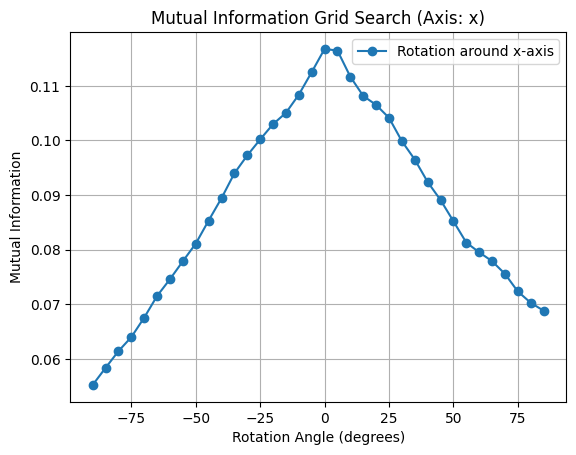

Best angle in x: 0 degrees, Highest Mutual Information: 0.1167


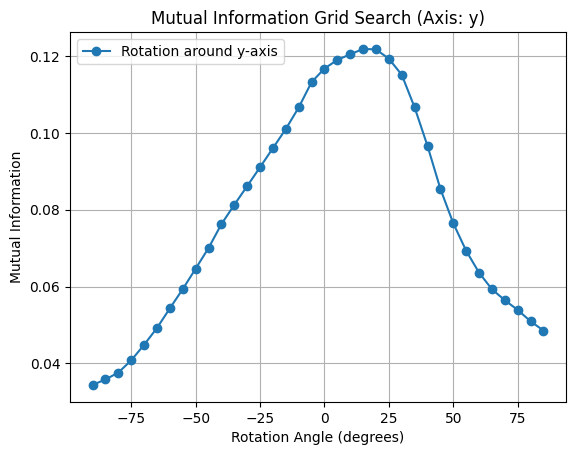

Best angle in y: 15 degrees, Highest Mutual Information: 0.1218


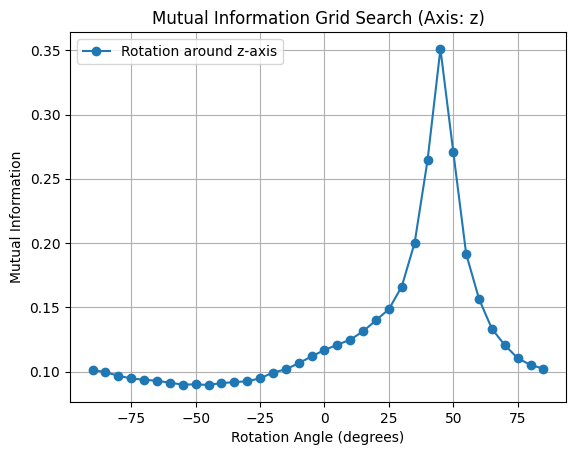

Best angle in z: 45 degrees, Highest Mutual Information: 0.3510


In [12]:
# Define a range of candidate angles (in degrees) to search over
a_lowest = -90   # Minimum angle
a_highest = 90   # Maximum angle
angle_range = np.arange(a_lowest, a_highest, 5)  # Grid search over angles at 5-degree intervals

# Convert the angles to radians for trigonometric calculations
angle_range_radians = np.deg2rad(angle_range)

# Different axes to rotate the image around
axes = ['x','y','z']

# for each axis in [x,y,z] we will rotate the image and calculate the mutual information
for axis in axes:
    # Storage for the mutual information values
    mi_values = np.zeros(len(angle_range))

    # T1 voxel coordinates to world coordinates
    T1_vox_to_world = T1_affine @ T1_voxel_coords

    for i, theta in enumerate(angle_range_radians):
        # Create the rotation matrix
        if axis == 'x':
            R = rotation_matrix_x(theta)
        elif axis == 'y':
            R = rotation_matrix_y(theta)
        else:
            R = rotation_matrix_z(theta)

        # rotate the world coordinates
        T1_vox_to_world_rotated = R @ T1_vox_to_world[:3, :]

        # world coordinates to T2 voxel coordinates
        T2_compute_rotated_to_vox = np.linalg.inv(T2_affine) @ np.vstack((T1_vox_to_world_rotated, np.ones((1, V1.size))))
        T2_rotated = map_coordinates(T2_data, T2_compute_rotated_to_vox[:3], order=3).reshape(T1_data.shape)

        # Compute the mutual information between the resampled T2 image and the fixed T1 image
        t1_masked, t2_masked = mask(T1_data, T2_rotated, threshold=10)
        hist = np.histogram2d(t1_masked, t2_masked, bins=32)[0]
        mi_value = calculate_mutual_information(hist, t1_masked, t2_masked, bins=32)
        
        # Store the MI value for this angle
        mi_values[i] = mi_value

    # plot the mutual information values
    plt.figure()
    plt.plot(angle_range, mi_values, 'o-', label=f'Rotation around {axis}-axis')
    plt.xlabel('Rotation Angle (degrees)')
    plt.ylabel('Mutual Information')
    plt.title(f'Mutual Information Grid Search (Axis: {axis})')
    plt.grid()
    plt.legend()
    plt.show()

    # Find the best angle corresponding to the highest mutual information
    best_angle_index = np.argmax(mi_values)
    best_angle = angle_range[best_angle_index]

    print(f"Best angle in {axis}: {best_angle} degrees, Highest Mutual Information: {mi_values[best_angle_index]:.4f}")



### Task 4: Explanations

For each of the possible axis, x, y and z, we have done a grid search of the rotation angle in a range from -90 degrees to 90 degrees with 5 degree steps. For each axis and each angle value we have created the corresponding rotation matrix, then resampled the T2-weighted volume accordingly and calculated the mutual information. The highest mutual information achieved is in axis z as expected from the prior tasks. The value obtained is 0.35 at a 45 degree angle.

In the plots above we can see the grid search for every axis and degree.

---

### Task 5: Perform automatic registration

Plot the negative mutual information, i.e. the energy function $E(\mathbf{w})= H_{F,M}-H_{F}-H_{M}$ for every angle in your grid search space. Select the one with the lowest energy (i.e., the best angle for registration) and transform the T2-weighted volume according to this angle.

Use the Viewer() function to visualize your registration result.

In [13]:
def calculate_energy_function(hist, t1_masked, t2_masked, bins=32):
    """
    Calculate the mutual information based on marginal and joint histograms.
    """
    # Compute the marginal histograms for T1 and T2
    hist_T1, _ = np.histogram(t1_masked, bins=bins)
    hist_T2, _ = np.histogram(t2_masked, bins=bins)

    # Calculate entropies for the marginal and joint histograms
    H_T1 = calculate_entropy(hist_T1)
    H_T2 = calculate_entropy(hist_T2)
    H_joint = calculate_entropy(hist)

    # Mutual Information = Entropy(T1) + Entropy(T2) - Joint Entropy(T1, T2)
    energy = H_joint - H_T1 - H_T2

    return energy

Best angle: 45 degrees, Lowest Energy: -0.3510


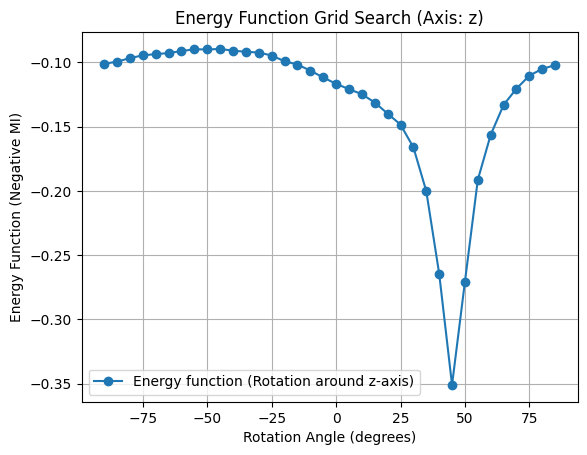

/var/folders/v6/q9xwr1gn2dvdngsx947dpj280000gn/T/ipykernel_17264/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


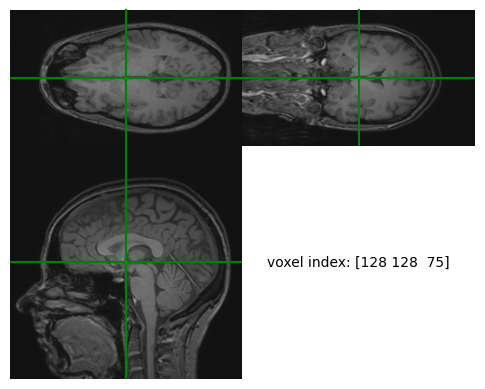

In [14]:
# Storage for the energy (negative MI) values
energy_values = np.zeros(len(angle_range))

# T1 voxel coordinates to world coordinates
T1_vox_to_world = T1_affine @ T1_voxel_coords

# Assuming rotation is around the z-axis
for i, theta_z in enumerate(angle_range_radians):
    
    # Create the rotation matrix
    R_z = rotation_matrix_z(theta_z)

    # rotate the world coordinates
    T1_vox_to_world_rotated = R_z @ T1_vox_to_world[:3, :]
      
    # world coordinates to T2 voxel coordinates
    T2_compute_rotated_to_vox = np.linalg.inv(T2_affine) @ np.vstack((T1_vox_to_world_rotated, np.ones((1, V1.size))))
    T2_rotated = map_coordinates(T2_data, T2_compute_rotated_to_vox[:3], order=3).reshape(T1_data.shape)

    # Compute the energy function
    t1_masked, t2_masked = mask(T1_data, T2_rotated, threshold=10)
    hist = np.histogram2d(t1_masked, t2_masked, bins=32)[0]
    energy = calculate_energy_function(hist, t1_masked, t2_masked, bins=32)
    
    # Store the energy value for this angle
    energy_values[i] = energy

# Find the angle with the lowest energy 
best_angle_index = np.argmin(energy_values)
best_angle = angle_range[best_angle_index]

print(f"Best angle: {best_angle} degrees, Lowest Energy: {energy_values[best_angle_index]:.4f}")

# Plot the graph 
plt.plot(angle_range, energy_values, marker='o', label='Energy function (Rotation around z-axis)')
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Energy Function (Negative MI)')
plt.title('Energy Function Grid Search (Axis: z)')
plt.grid()
plt.legend()
plt.show()

# Get the best rotation angle
best_theta_z = np.deg2rad(best_angle)

# Create the rotation matrix for the best angle
R_z_best = rotation_matrix_x(best_theta_z)

# Apply the best rotation matrix to the voxel coordinates
T2_voxel_coords_best_rotated = R_z_best @ T2_voxel_coords_n[:3, :]

# Resample the T2-weighted volume using the best rotation
T2_data_best_resampled = scipy.ndimage.map_coordinates(T2_data, T2_voxel_coords_best_rotated, order=3).reshape(T1_data.shape)

# Visualize the final registration result
Viewer(T2_data_best_resampled / T2_data_best_resampled.max() + T1_data / T1_data.max())


### Task 5: Explanation

In this case, instead of calculating the mutual information, we plot the energy function. This time, since we now the rotation has been done in the z axis, we only comput the function in this axis for the same range of angles as before. Then as it can be seen in the plot, the energy function is the negative mutual information since we obtain the same distribution but flipped arround. Hence, the best degree still is 45, and the lowest energy achieved is -0.35.

---

### Task 6: Compare the joint histogram before and after registration

Visualize the joint histogram after registration. Compare the result to your initial joint histogram (i.e., before registration) and discuss your findings in your report.

In [ ]:
# T1 voxel coordinates to world coordinates
T1_vox_to_world_B = T1_affine @ T1_voxel_coords

angle = 45
theta_z = np.deg2rad(angle)

# Create the rotation matrix
R_z_B = rotation_matrix_z(theta_z)

# rotate the world coordinates
T1_vox_to_world_rotated_B = R_z_B @ T1_vox_to_world_B[:3, :]
    
# world coordinates to T2 voxel coordinates
T2_compute_rotated_to_vox_B = np.linalg.inv(T2_affine) @ np.vstack((T1_vox_to_world_rotated_B, np.ones((1, V1.size))))
T2_rotated_B = map_coordinates(T2_data, T2_compute_rotated_to_vox_B[:3], order=3).reshape(T1_data.shape)

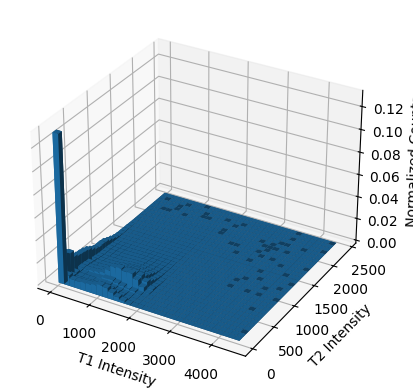

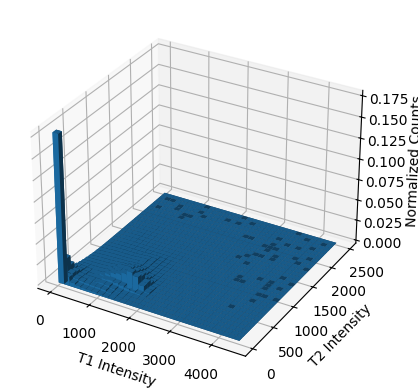

array([[532699.,  84005.,  49106., ...,      0.,      0.,      0.],
       [ 32355.,  34256.,  29108., ...,      0.,      0.,      0.],
       [ 15594.,  19975.,  18033., ...,      0.,      0.,      0.],
       ...,
       [     0.,      0.,      0., ...,      0.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,      0.,      0.],
       [     1.,      0.,      0., ...,      0.,      0.,      0.]])

In [19]:
# Before registration: 
# Use the original T2 image (unregistered)
t1_masked_before, t2_masked_before = mask(T1_data, T2_data_resampled, threshold=10)

# Compute the joint histogram before registration
hist_before = np.histogram2d(t1_masked_before, t2_masked_before, bins=32)[0]

# Plot the joint histogram before registration
plot_3d_histogram(t1_masked_before, t2_masked_before, bins=32)

# After registration:
# Registered T2 image (after intensity-based registration)
t1_masked_after, t2_masked_after = mask(T1_data, T2_rotated_B, threshold=10)

# Compute the joint histogram after registration
hist_after = np.histogram2d(t1_masked_after, t2_masked_after, bins=32)[0]

# Plot the joint histogram after registration
plot_3d_histogram(t1_masked_after, t2_masked_after, bins=32)


### Task 6: Explanation

Finally, we compare the joint histogram before and after registration. We can observe from the plots that the mutual information values are higher in the pos-registration, therefore we can say that the registration process improved the alignment between the T1-weighted and T2-weighted scans. The distribution of voxel intensity pairs is more focused around higher intensities after registration, which further suggests improved alignment.
Before registration, the histograms had lower peaks and showed more spread across intensity ranges, indicating less correspondence between the two images.

---

### Conclusion

The mutual information-based registration method proved effective in aligning T1-weighted and T2-weighted MRI scans. By applying grid search over candidate rotation angles, we maximized the mutual information, indicating improved alignment between the two images. Post-registration joint histograms showed increased correspondence between voxel intensities, confirming that the method successfully enhanced the registration quality. This approach demonstrates the value of mutual information in medical image analysis, especially for multimodal image registration.